In [2]:
import sklearn
import PIL
from matplotlib import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import transform, color
from PIL import Image 
import numpy as np
from os import listdir
from os.path import isfile, join
import os

## Dataexploration

### General properties of data

- all pictures in png-format 
- no consistent size and image ratio
- 13779 images parsitized, 13779 images uninfected, total 27558 images  
- all images are in color
- high amount of features, thus feature engineering is indicated

### Load data

images parasitized

In [3]:
sample_images_positive = []
i=0
for filename in listdir('cell_images/Parasitized/'):
    if i < 10:
        img = plt.imread('cell_images/Parasitized/' + filename)
        sample_images_positive.append(img)
        i+=1

images uninfected

In [4]:
sample_images_negative = []
i=0
for filename in listdir('cell_images/Uninfected/'):
    if i < 10:
        img = plt.imread('cell_images/Uninfected/' + filename)
        sample_images_negative.append(img)
        i+=1

### Qualitative analysis and visualization

<Figure size 432x288 with 0 Axes>

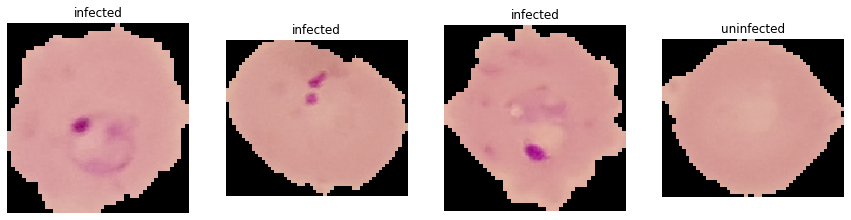

In [5]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(15,15))
ax1 = axes[0]
ax1.imshow(sample_images_positive[0], cmap='Greys_r')
ax1.set_title('infected')
ax1.axis('off')
ax2 = axes[1]
ax2.imshow(sample_images_positive[5], cmap='Greys_r')
ax2.set_title('infected')
ax2.axis('off')
ax3 = axes[2]
ax3.imshow(sample_images_positive[9], cmap='Greys_r')
ax3.set_title('infected')
ax3.axis('off')
ax4 = axes[3]
ax4.imshow(sample_images_negative[0], cmap='Greys_r')
ax4.set_title('uninfected')
ax4.axis('off');

summary:   
- images with infections show darker stains of differing color. These can have very differnt forms, sizes and shades. The morpholoy of the stains seems of secondary relevance
- the highest contrast within the images shows on the border between the samples and the black background. This might pose a disadvantage for the algorithm

## Data representation

### Grayscale

It is indicated to change the color scheme to grayscale due to the following reasons
- as the color agent might take on a differing color in different data samples, the generalization is increased by changing the color scheme to grayscale
- it is easier to handle a dataset with only one color channel
- the calculation effort is reduced

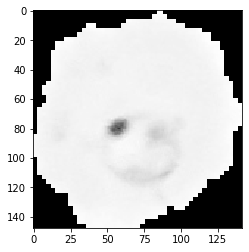

In [5]:
image_grayscale = color.rgb2gray(sample_images_positive[0])
plt.imshow(image_grayscale, cmap='Greys_r')

- The stains of the infected cells are also well discernible on a grayscale dark-light continuum   
- The black background again shows as a disadvantage as the highest contrast is given between the black background and teh sample area.

### Set the background to a bright shade

This measure of preprocessing is taken due to the following reasons:
- the stains of the infected cells are then the darkest areas in the image and this might make it easier for the algorithm to discern infected from uninfected samples
- the border between the sample and the background is no longer the dominating pattern in the images

padding function to keep the resolution of the pictures

In [6]:
def padding(image, size):
    desired_size = size
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = image.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('RGB',(desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_im

function for brightening the image background

In [7]:
def brighten(image):
    max_ = np.max(image)
    image[image==0.0] = max_
    return image

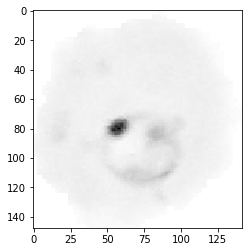

In [8]:
img = sample_images_positive[0]
img = np.array(img)
img = color.rgb2gray(img)
img = brighten(img)
plt.imshow(img, cmap='Greys_r');

In [9]:
X_positive_bright = []
for filename in listdir('cell_images/Parasitized/'):
    img = Image.open('cell_images/Parasitized/' + filename)
    img = padding(img, 220)
    img = np.array(img)
    img = color.rgb2gray(img)
    img = brighten(img.reshape(220*220))
    img = transform.resize(img.reshape(220,220), (100,100))
    X_positive_bright.append(img)
X_positive_bright = np.array(X_positive_bright)

In [10]:
X_positive_bright.shape

(13779, 100, 100)

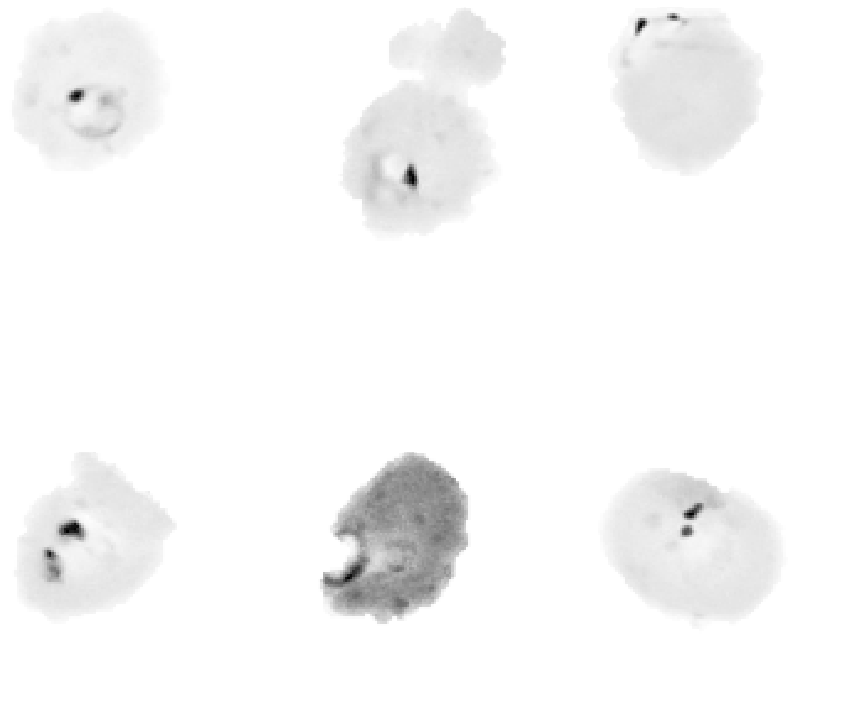

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_positive_bright[i], cmap='Greys_r')
    axi.axis('off')

In [12]:
X_negative_bright = []
for filename in listdir('cell_images/Uninfected/'):
    img = Image.open('cell_images/Uninfected/' + filename)
    img = padding(img, 220)
    img = np.array(img)
    img = color.rgb2gray(img)
    img = brighten(img.reshape(220*220))
    img = transform.resize(img.reshape(220,220), (100,100))
    X_negative_bright.append(img)
X_negative_bright = np.array(X_negative_bright)

### Flatten

In [13]:
X_positive_bright = X_positive_bright.reshape(13779, 100*100)
X_negative_bright = X_negative_bright.reshape(13779, 100*100)
X_positive_bright.shape, X_negative_bright.shape

((13779, 10000), (13779, 10000))

### Normalization

In [14]:
X_positive_bright.min(), X_positive_bright.max(), X_negative_bright.min(), X_negative_bright.max()

(0.0806995401124341,
 0.9148203921568625,
 0.05867339546138877,
 0.9469815686274505)

the images already are normalized, apparently between 0 (black) and 1 (white)

### Feature Engineering: Principal Component Analysis

For feature engineering principal component analysis should be adopted due to the following reasons:
- the number of features can be reduced by this measure
- components are identified that explain a high amount of variance. Through this the training of the model is simplified  
- for the support vector machine as the model class of choice the principal component analysis is indicated in any case

In [15]:
from sklearn.decomposition import PCA

In [16]:
X_full = np.row_stack((X_positive_bright, X_negative_bright))

In [17]:
pca_full_variance = PCA(n_components = 0.95) 
pca_full_variance.fit(X_full) 
pca_full_variance.components_.shape

(96, 10000)

about 100 components already explain 95% of variance

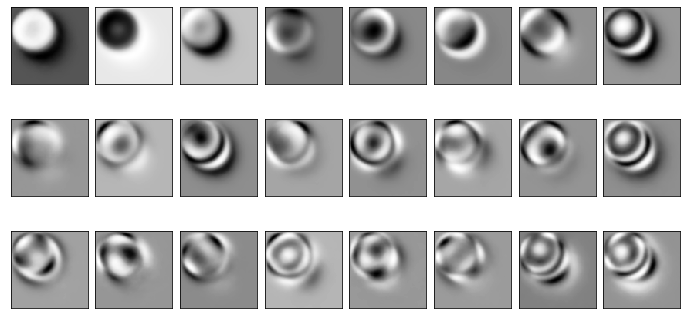

In [18]:
fig, axes = plt.subplots(3, 8, figsize=(12, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_full_variance.components_[i].reshape(100, 100), cmap='Greys_r')

- these visual results of the pca seem very promising: looking at the first two principal components the first shows a light color within the sample area indicating an uninfected sample and the second a dark color indicating a parsitized sample

In [19]:
X_reduced = pca_full_variance.transform(X_full)
X_reduced.shape

(27558, 96)

## Support Vector Machine

### Rationale for using this model class

I decided to use SVM for the following reasons:
- the algorithm is especially well suited for dichotomous classification   
- it is robust against overfitting even with a high number of features   
- with the rbf kernel it can cover non-linearity very well

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

### Prepare data

create target variable

In [21]:
y_positive = np.ones(X_positive_bright.shape[0])
y_negative = np.zeros(X_negative_bright.shape[0])
y_positive.shape, y_negative.shape

((13779,), (13779,))

In [22]:
y = np.hstack((y_positive, y_negative))

test and training dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, stratify=y, train_size=0.5)

validation test and training dataset

In [24]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

### Training and optimization of the model

Determine the ranges of the hyperparameters for gridsearch

In [36]:
Cs = np.logspace(16, 17, base=2, num=10)
gammas = np.logspace(-12, -6, base=2, num=10)
param_grid = {
    'C': Cs,
    'gamma': gammas
}

optimize model with validation dataset

In [37]:
model_svc_val = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    n_jobs=4,
    scoring="r2"
)

In [38]:
model_svc_val.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': array([ 65536.        ,  70782.79504805,  76449.64713766,  82570.18592591,
        89180.73345143,  96320.51968577, 104031.91534179, 112360.68332052,
       121356.25028892, 131072.        ]),
                         'gamma': array([0.00024414, 0.00038755, 0.0006152 , 0.00097656, 0.0015502 ,
       0.00246078, 0.00390625, 0.00620079, 0.00984313, 0.015625  ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [39]:
pred_val = model_svc_val.predict(X_test_val)

In [40]:
accuracy_score(y_test_val, pred_val)

0.8817126269956459

In [41]:
model_svc_val.best_params_

{'C': 70782.79504804616, 'gamma': 0.0009765625}

In [42]:
model_svc = SVC(C=70782, gamma=0.000977)
model_svc.fit(X_train, y_train)

SVC(C=70782, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.000977, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Evaluation

In [43]:
pred = model_svc.predict(X_test)

In [44]:
accuracy_score(y_test, pred)

0.8797445387909137

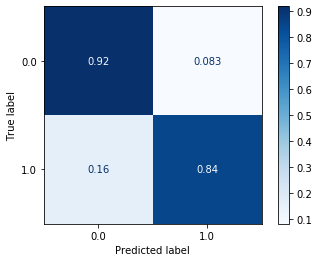

In [53]:
plot_confusion_matrix(model_svc, X_test, y_test,
                     cmap=plt.cm.Blues,
                                 normalize='true')
plt.show();